In [431]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Reshape, Concatenate, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [432]:
# Data loading and preprocessing
xie_1 = pd.read_csv(r'well_log.csv', encoding='ANSI')
print(xie_1.columns)

Index(['CNL_Z', 'Density_0108', 'GR_Z', 'P-wave_0108', 'S-wave_0108'], dtype='object')


In [433]:
# Normalization (automatic normalization)
scalers = {}  # Dictionary to store scalers for inverse transformation later
for col in xie_1.columns[:13]:
    scaler = MinMaxScaler()  
    xie_1[col] = scaler.fit_transform(xie_1[col].values.reshape(-1,1))
    scalers[col] = scaler  # Store scaler for later use

In [434]:
# Convert from dataframe to array
xie_1_1 = np.array(xie_1)  # Extract features - xie_1
data = xie_1_1
cnl = data[:,0]   # CNL_Z corresponding to index 0
den = data[:,1]   # Density_0108 corresponding to index 1
gr = data[:,2]    # GR_Z corresponding to index 2
vp = data[:,3]    # P-wave_0108 corresponding to index 3
vs = data[:,4]    # S-wave_0108 corresponding to index 4

vp0 = np.expand_dims(vp, 1)
vs0 = np.expand_dims(vs, 1)
den0 = np.expand_dims(den, 1)
vpvsden = np.concatenate((vp0, vs0, den0), axis=1)
print(vpvsden.shape)

gr0 = np.expand_dims(gr, 1)
cnl0 = np.expand_dims(cnl, 1)
grcnl = np.concatenate((gr0, cnl0), axis=1)
print(grcnl.shape)

(1361, 3)
(1361, 2)


In [435]:
# Modified: Create multi-output feature dataset
def create_dataset_multi_output(X, y1, y2, y3, seq_len):
    """
    Create multi-output dataset
    X: input features
    y1: first output (vp)
    y2: second output (vs)
    y3: third output (den)
    seq_len: sequence length
    """
    features = []
    targets_vp = []
    targets_vs = []
    targets_den = []
    
    for i in range(0, len(X) - seq_len, 1):  # 1 is the step size
        data = X[i:i+seq_len]  # Sequence data  
        label_vp = y1[i+seq_len//2]  # vp label data
        label_vs = y2[i+seq_len//2]  # vs label data
        label_den = y3[i+seq_len//2]  # den label data
        # Save to features and labels
        features.append(data)
        targets_vp.append(label_vp)
        targets_vs.append(label_vs)
        targets_den.append(label_den)
    
    # Return
    return np.array(features), np.array(targets_vp), np.array(targets_vs), np.array(targets_den)


In [436]:
# Sequence length of 9, create new dataset with labels
Len1 = 9
# Modified: use grcnl as input, vp, vs, den as output
(x1, y1_vp, y1_vs, y1_den) = create_dataset_multi_output(grcnl, vp, vs, den, Len1)
print(x1.shape, y1_vp.shape, y1_vs.shape, y1_den.shape)

x1 = x1.reshape(x1.shape[0], x1.shape[1]*x1.shape[2])
print(x1.shape)

(1352, 9, 2) (1352,) (1352,) (1352,)
(1352, 18)


In [437]:
# Define multi-output STABGCN model
def build_multi_output_stabgcn_model(input_shape):
    """
    Multi-output STABGCN model for simultaneous VP, VS and DEN prediction
    """
    # Input layer
    inputs = Input(shape=input_shape)
    features = input_shape[0]
    
    # ------- 2D-CNN branch -------
    # Reshape to square image
    side_length = int(np.ceil(np.sqrt(features)))
    padding_needed = side_length * side_length - features
    
    x_padded = tf.pad(inputs, [[0, 0], [0, padding_needed]])
    reshaped_2d = Reshape((side_length, side_length, 1))(x_padded)
    
    # Convolutional layers
    conv2d = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(0.001))(reshaped_2d)
    pool = MaxPooling2D(pool_size=(2, 2))(conv2d)
    dropout_cnn = Dropout(0.2)(pool)
    cnn_flat = Flatten()(dropout_cnn)
    
    # ------- BiGRU branch -------
    # Build sequence representation
    seq_length = features // 2  # For grcnl, each time step has 2 features (gr, cnl)
    
    # Reshape to sequence
    x_seq = Reshape((seq_length, 2))(inputs[:, :seq_length*2])  # Each time step has 2 features
    
    # BiGRU layer
    bigru = Bidirectional(GRU(32, 
                            recurrent_regularizer=tf.keras.regularizers.l2(0.001),
                            kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x_seq)
    dropout_gru = Dropout(0.2)(bigru)
    
    # Merge features
    merged = Concatenate()([cnn_flat, dropout_gru])
    
    # Shared layers
    shared = Dense(128, activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
    shared_dropout = Dropout(0.2)(shared)
    
    # Branch network - VP prediction
    vp_branch = Dense(64, activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    vp_dropout = Dropout(0.2)(vp_branch)
    vp_output = Dense(1, name='vp_output')(vp_dropout)  # VP output
    
    # Branch network - VS prediction
    vs_branch = Dense(64, activation='relu', 
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    vs_dropout = Dropout(0.2)(vs_branch)
    vs_output = Dense(1, name='vs_output')(vs_dropout)  # VS output
    
    # Branch network - DEN prediction
    den_branch = Dense(64, activation='relu', 
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    den_dropout = Dropout(0.2)(den_branch)
    den_output = Dense(1, name='den_output')(den_dropout)  # DEN output
    
    # Create model with three outputs
    model = Model(inputs=inputs, outputs=[vp_output, vs_output, den_output])
    
    # Learning rate decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=100,
        decay_rate=0.9)
    
    optimizer = Adam(learning_rate=lr_schedule)
    
    # Compile model with MSE loss for all outputs
    model.compile(
        optimizer=optimizer, 
        loss={'vp_output': 'mse', 'vs_output': 'mse', 'den_output': 'mse'},
        loss_weights={'vp_output': 1.0, 'vs_output': 1.0, 'den_output': 1.0}  # Equal weights for all three outputs
    )
    
    return model


In [438]:
# Define data shape
features = Len1*2  # Input feature dimensions, Len1*2 (because grcnl has 2 features per time step)
input_shape = (features,)  # Define input shape

# Build model
model3 = build_multi_output_stabgcn_model(input_shape)

# Output model structure
model3.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 18)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_Pad_33 (TensorFlowO [(None, 25)]         0           input_34[0][0]                   
__________________________________________________________________________________________________
reshape_66 (Reshape)            (None, 5, 5, 1)      0           tf_op_layer_Pad_33[0][0]         
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 5, 5, 32)     320         reshape_66[0][0]                 
___________________________________________________________________________________________

In [439]:
# Data preparation
source_points = x1
target_points_vp = y1_vp
target_points_vs = y1_vs
target_points_den = y1_den
print(source_points.shape, target_points_vp.shape, target_points_vs.shape, target_points_den.shape)

# Standardize data
scaler = StandardScaler()
source_points_scaled = scaler.fit_transform(source_points)

(1352, 18) (1352,) (1352,) (1352,)


In [440]:
# Split data into training and testing sets
X_train, X_test, y_train_vp, y_test_vp, y_train_vs, y_test_vs, y_train_den, y_test_den = train_test_split(
    source_points_scaled, target_points_vp, target_points_vs, target_points_den, test_size=0.15, random_state=42
)
print(X_train.shape, X_test.shape, y_train_vp.shape, y_test_vp.shape, y_train_vs.shape, y_test_vs.shape, y_train_den.shape, y_test_den.shape)

# Train model - multi-output
history = model3.fit(
    X_train, 
    {'vp_output': y_train_vp, 'vs_output': y_train_vs, 'den_output': y_train_den}, 
    epochs=15, 
    batch_size=100, 
    validation_split=0.05, 
    verbose=1
)

(1149, 18) (203, 18) (1149,) (203,) (1149,) (203,) (1149,) (203,)
Train on 1091 samples, validate on 58 samples
Epoch 1/15
1091/1091 [==============================] - 3s 3ms/sample - loss: 0.8368 - vp_output_loss: 0.0865 - vs_output_loss: 0.0874 - den_output_loss: 0.1822 - val_loss: 0.5995 - val_vp_output_loss: 0.0533 - val_vs_output_loss: 0.0456 - val_den_output_loss: 0.0329
Epoch 2/15
1091/1091 [==============================] - 0s 92us/sample - loss: 0.6111 - vp_output_loss: 0.0488 - vs_output_loss: 0.0513 - den_output_loss: 0.0540 - val_loss: 0.5573 - val_vp_output_loss: 0.0394 - val_vs_output_loss: 0.0304 - val_den_output_loss: 0.0436
Epoch 3/15
1091/1091 [==============================] - 0s 92us/sample - loss: 0.5496 - vp_output_loss: 0.0374 - vs_output_loss: 0.0404 - den_output_loss: 0.0386 - val_loss: 0.5104 - val_vp_output_loss: 0.0375 - val_vs_output_loss: 0.0315 - val_den_output_loss: 0.0213
Epoch 4/15
1091/1091 [==============================] - 0s 92us/sample - loss: 0.5

203/203 [==============================] - 0s 80us/sample - loss: 0.2507 - vp_output_loss: 0.0102 - vs_output_loss: 0.0095 - den_output_loss: 0.0075
Test Loss: [0.2506509446745436, 0.01022037, 0.009505449, 0.0075412453]


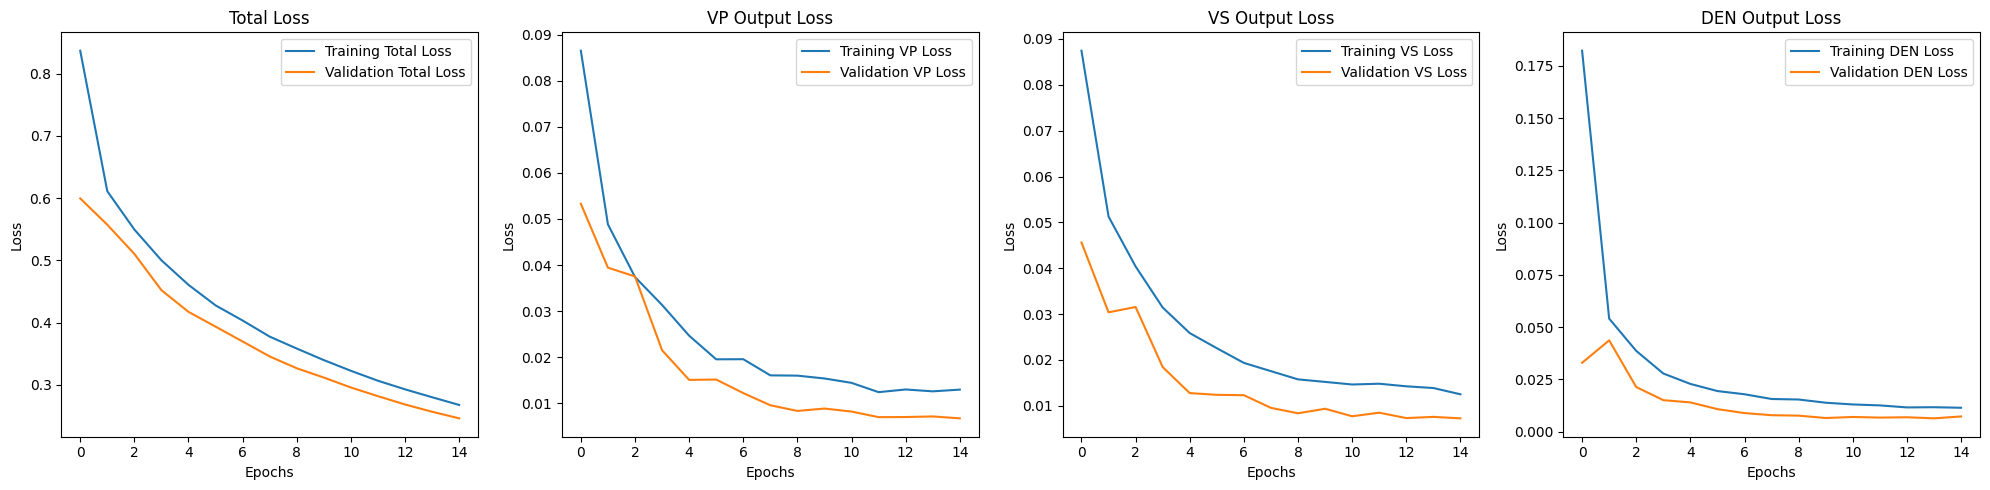

In [441]:
# Evaluate model - multi-output
eval_results = model3.evaluate(
    X_test, 
    {'vp_output': y_test_vp, 'vs_output': y_test_vs, 'den_output': y_test_den},
    verbose=1
)
print(f'Test Loss: {eval_results}')

# Plot training loss and validation loss vs epochs - multi-output
plt.figure(figsize=(20, 5))

# Plot total loss
plt.subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Training Total Loss')
plt.plot(history.history['val_loss'], label='Validation Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()

# Plot VP output loss
plt.subplot(1, 4, 2)
plt.plot(history.history['vp_output_loss'], label='Training VP Loss')
plt.plot(history.history['val_vp_output_loss'], label='Validation VP Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VP Output Loss')
plt.legend()

# Plot VS output loss
plt.subplot(1, 4, 3)
plt.plot(history.history['vs_output_loss'], label='Training VS Loss')
plt.plot(history.history['val_vs_output_loss'], label='Validation VS Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VS Output Loss')
plt.legend()

# Plot DEN output loss
plt.subplot(1, 4, 4)
plt.plot(history.history['den_output_loss'], label='Training DEN Loss')
plt.plot(history.history['val_den_output_loss'], label='Validation DEN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DEN Output Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [442]:
# Generate test predictions - multi-output
# Make predictions on the test set instead of the entire dataset
predictions = model3.predict(X_test)
vp_predictions = predictions[0]  # VP predictions
vs_predictions = predictions[1]  # VS predictions
den_predictions = predictions[2]  # DEN predictions

# Get the column names for VP, VS, and DEN from the original dataframe
vp_column_name = xie_1.columns[3]  # P-wave_0108 is at index 3
vs_column_name = xie_1.columns[4]  # S-wave_0108 is at index 4
den_column_name = xie_1.columns[1]  # Density_0108 is at index 1

# Inverse transform predictions and labels using stored scalers
vp_scaler = scalers[vp_column_name]
vs_scaler = scalers[vs_column_name]
den_scaler = scalers[den_column_name]

# Reshape for inverse transform
vp_predictions_denorm = vp_scaler.inverse_transform(vp_predictions)
vp_actual_denorm = vp_scaler.inverse_transform(y_test_vp.reshape(-1, 1))

vs_predictions_denorm = vs_scaler.inverse_transform(vs_predictions)
vs_actual_denorm = vs_scaler.inverse_transform(y_test_vs.reshape(-1, 1))

den_predictions_denorm = den_scaler.inverse_transform(den_predictions)
den_actual_denorm = den_scaler.inverse_transform(y_test_den.reshape(-1, 1))

VP R² Score (denormalized test data): 0.6012440344225596
VS R² Score (denormalized test data): 0.6930006574940719
DEN R² Score (denormalized test data): 0.44634575851865577


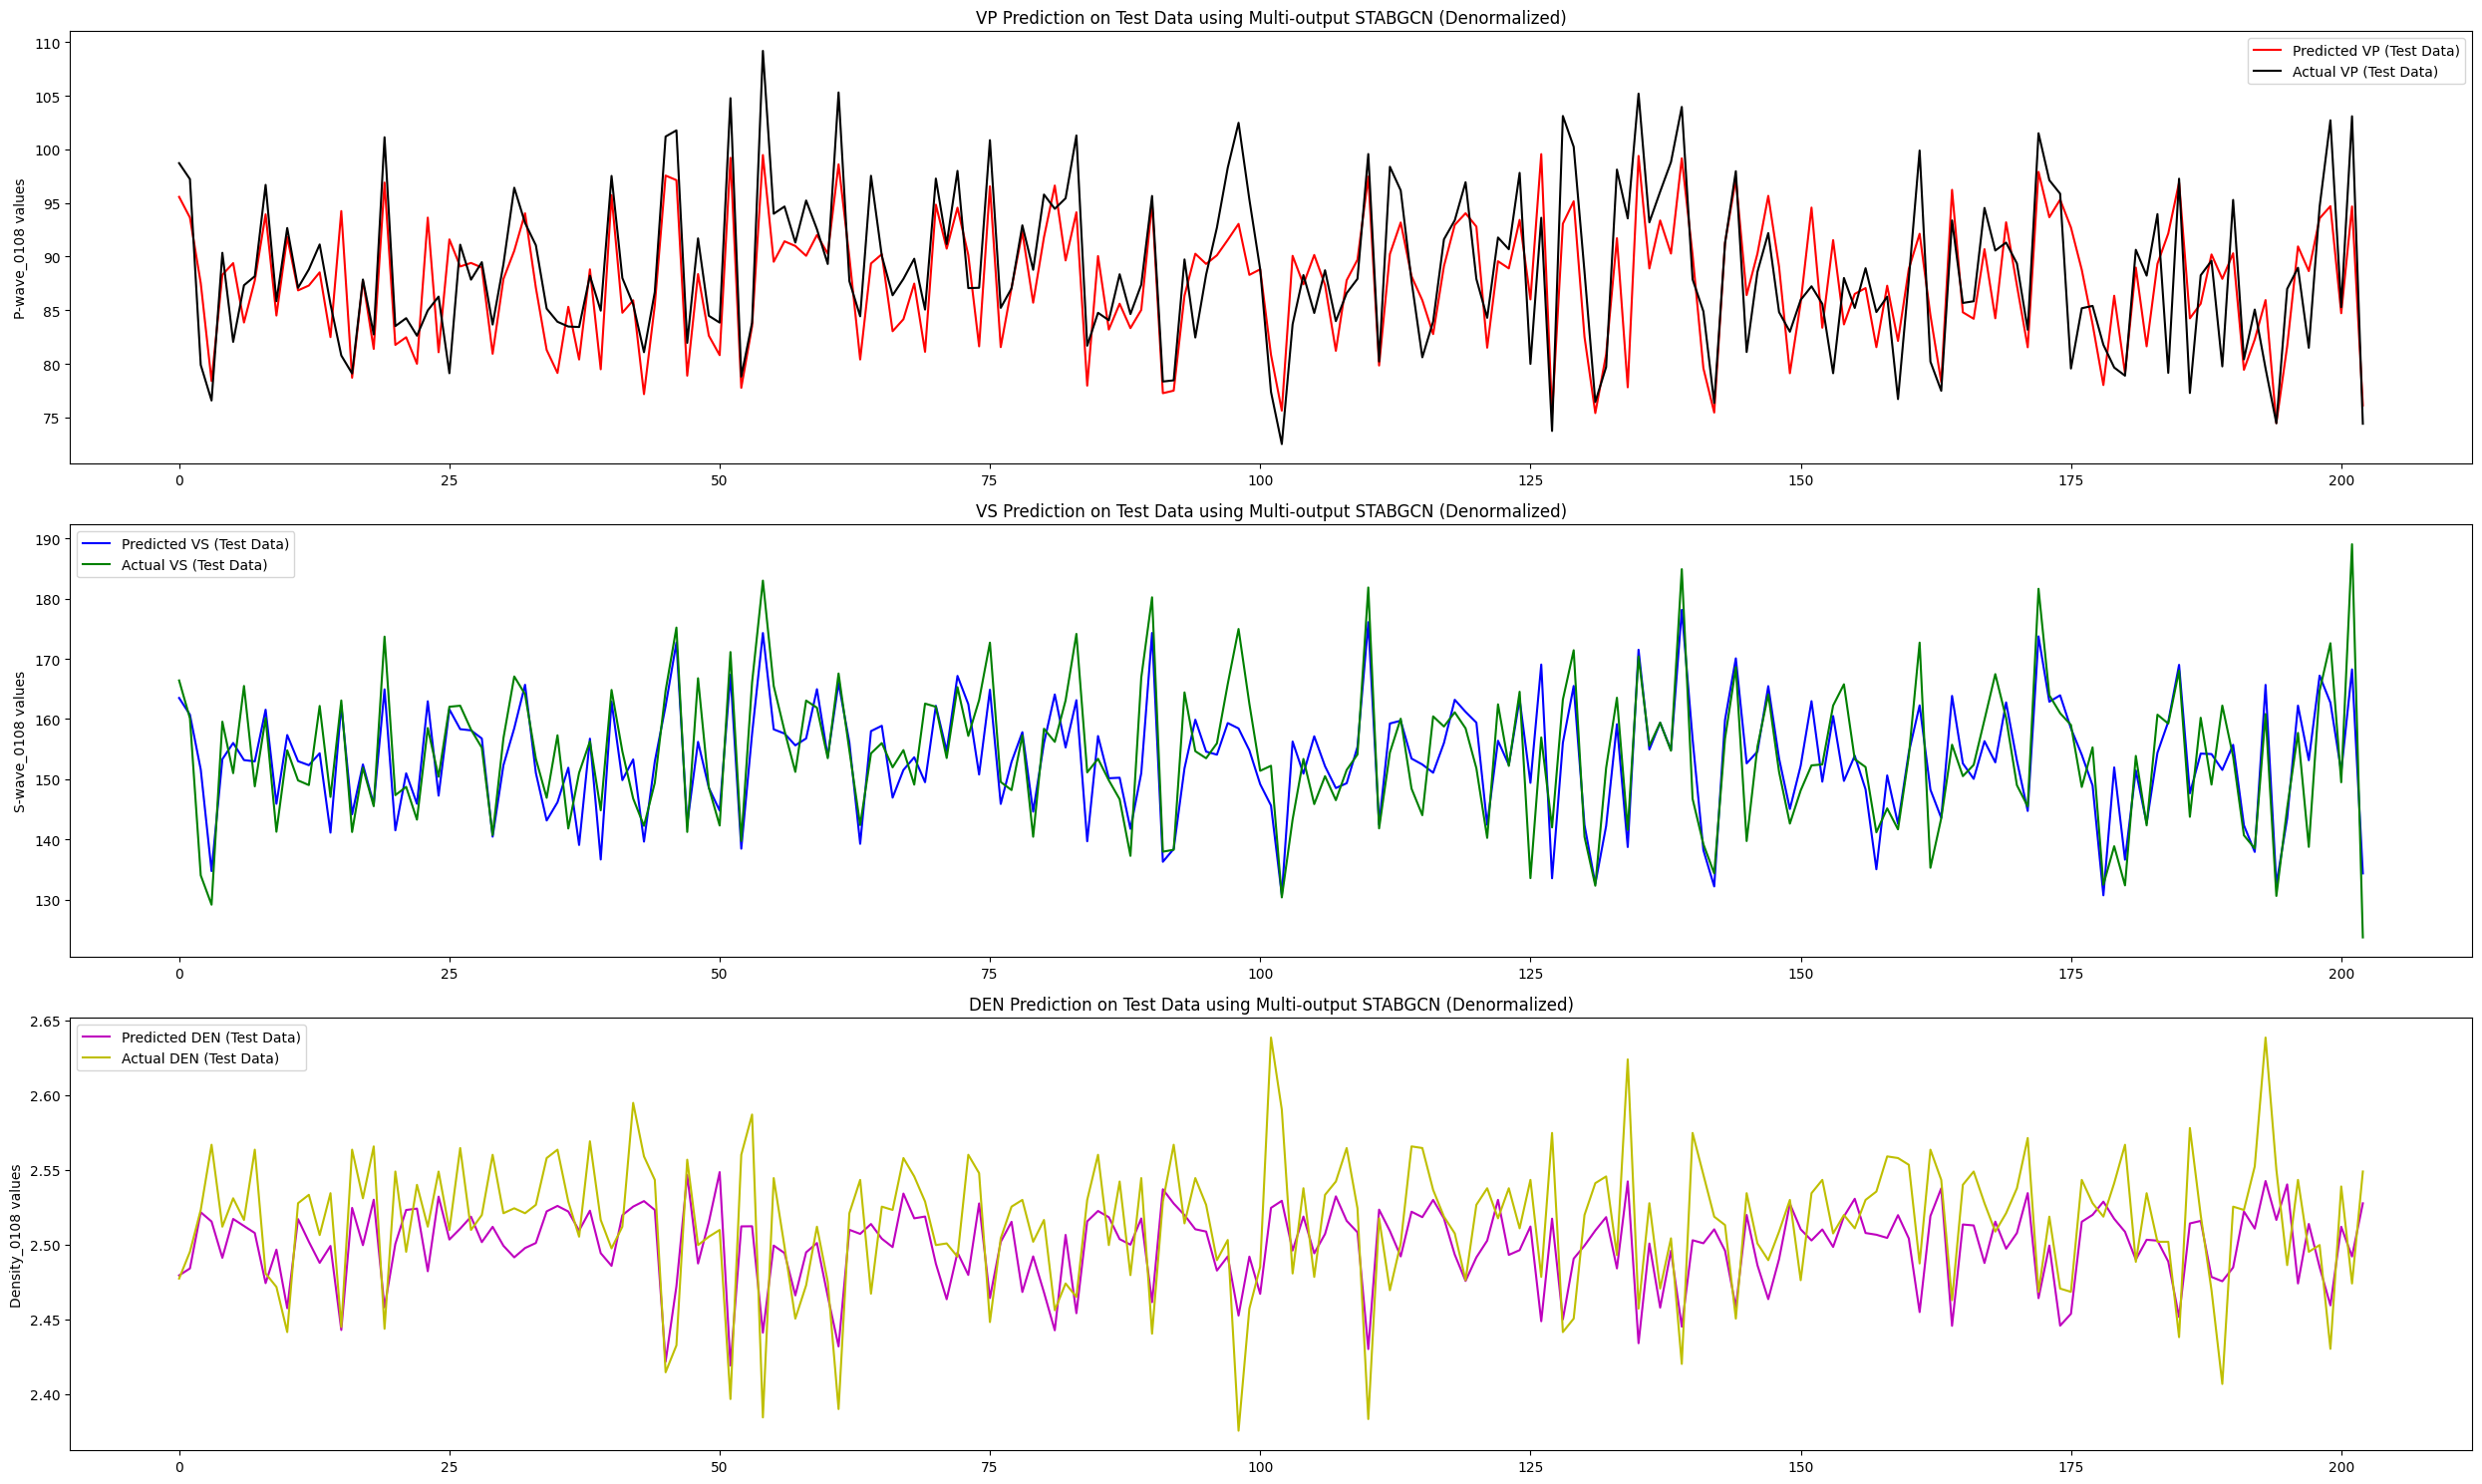

In [443]:
# Calculate R² scores with denormalized test data
r2_vp = r2_score(vp_actual_denorm, vp_predictions_denorm)
print(f'VP R² Score (denormalized test data): {r2_vp}')

r2_vs = r2_score(vs_actual_denorm, vs_predictions_denorm)
print(f'VS R² Score (denormalized test data): {r2_vs}')

r2_den = r2_score(den_actual_denorm, den_predictions_denorm)
print(f'DEN R² Score (denormalized test data): {r2_den}')

# Plot - VP prediction results with denormalized test data
plt.figure(figsize=(25, 15))
plt.subplot(3, 1, 1)
plt.plot(vp_predictions_denorm, 'r', label='Predicted VP (Test Data)')
plt.plot(vp_actual_denorm, 'k', label='Actual VP (Test Data)')
plt.title('VP Prediction on Test Data using Multi-output STABGCN (Denormalized)')
plt.legend()
plt.ylabel(f'{vp_column_name} values')

# Plot - VS prediction results with denormalized test data
plt.subplot(3, 1, 2)
plt.plot(vs_predictions_denorm, 'b', label='Predicted VS (Test Data)')
plt.plot(vs_actual_denorm, 'g', label='Actual VS (Test Data)')
plt.title('VS Prediction on Test Data using Multi-output STABGCN (Denormalized)')
plt.legend()
plt.ylabel(f'{vs_column_name} values')

# Plot - DEN prediction results with denormalized test data
plt.subplot(3, 1, 3)
plt.plot(den_predictions_denorm, 'm', label='Predicted DEN (Test Data)')
plt.plot(den_actual_denorm, 'y', label='Actual DEN (Test Data)')
plt.title('DEN Prediction on Test Data using Multi-output STABGCN (Denormalized)')
plt.legend()
plt.ylabel(f'{den_column_name} values')

plt.tight_layout()
plt.show()